<a href="https://colab.research.google.com/github/KDHarsh24/Face-Model/blob/main/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install insightface opencv-python-headless numpy onnxruntime-gpu scipy scikit-learn albumentations tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 26.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp312-cp312-linux_x86_64.whl size=1070074 sha256=23d170a25d09e2df2218a76e744948eca39c0a668530d8131030fa298ff85bac
  Stored in directory: /root/.cache/pip/wheels/73/3c/e2/6d4815e8a8b33a2006554d65ce0d1f973e768f4c7a222fa675
Successfully built insightface


# 🔧 Initial Setup & Imports

This section includes all necessary imports and configurations required for face detection and recognition using the InsightFace library with the **antelopev2** model for maximum accuracy.

### 📦 Libraries Imported

- `cv2`: OpenCV for image and video processing
- `numpy`: For numerical operations on arrays
- `os`: For handling file system operations
- `matplotlib.pyplot`: For displaying images and visualizations
- `cosine_similarity` from `sklearn.metrics.pairwise`: To compare face embeddings
- `files` from `google.colab`: To upload files in Google Colab
- `FaceAnalysis` from `insightface.app`: Main API for face detection and recognition
- `albumentations`: For optional image augmentations
- `torch`: To check if GPU (CUDA) is available

---

### ⚙️ Device Configuration

Check if CUDA-enabled GPU is available. If so, it uses the GPU (`ctx_id=0`), otherwise it defaults to CPU (`ctx_id=-1`).

### 🎯 Model Configuration

This notebook uses the **antelopev2** model, which provides:
- **Highest accuracy** among InsightFace models
- **State-of-the-art performance** for face recognition
- **Robust embeddings** for challenging conditions
- **Higher computational requirements** (recommended with GPU)

```python
ctx_id = 0 if torch.cuda.is_available() else -1
print("✅ Using GPU" if ctx_id == 0 else "⚠️ Using CPU")
```

In [ ]:
import cv2, os, time
import numpy as np
import torch
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed
from insightface.app import FaceAnalysis
import albumentations as A

# Colab helper is optional; avoid import errors on Windows/local
try:
    from google.colab import files  # type: ignore
except Exception:
    files = None

# ---- STEP 1: Detect execution environment and choose provider GPU or CPU ----
def get_insightface_context():
    if torch.cuda.is_available():
        print("✅ GPU (CUDA) detected and will be used for InsightFace.")
        return 0, ['CUDAExecutionProvider', 'CPUExecutionProvider']
    print("⚠️ No GPU detected. Using CPU.")
    return -1, ['CPUExecutionProvider']

# ---- STEP 2: Initialize FaceAnalysis (antelopev2 for maximum accuracy) ----
# Model options: 'buffalo_s' (fast), 'buffalo_l' (accurate), 'antelopev2' (very strong, heavier)
MODEL_NAME = os.getenv('IFACE_MODEL', 'antelopev2')
DET_SIZE = (1024, 1024)  # smaller = faster; try (512,512) for more FPS, (1024,1024) for max accuracy

def initialize_model(ctx_id, providers):
    # Remove cached models to force re-download
    insightface_root = os.path.join(os.path.expanduser('~'), '.insightface')
    if os.path.exists(insightface_root):
        print(f"MODEL: Removing cached InsightFace models from: {insightface_root}")
        shutil.rmtree(insightface_root)

    print(f"MODEL: Initializing InsightFace model: {MODEL_NAME} | det_size={DET_SIZE} | providers={providers}")
    app = FaceAnalysis(name=MODEL_NAME, providers=providers)
    app.prepare(ctx_id=ctx_id, det_size=DET_SIZE)
    print("MODEL: InsightFace model initialized.")
    return app

# ---- STEP 3: Prepare face database ----
def initialize_face_database(folder_path="/content/face_database", clear=False):
    # if clear and os.path.exists(folder_path):
    #     shutil.rmtree(folder_path)
    #     print(f"🗑️ Cleared existing database at: {folder_path}")
    os.makedirs(folder_path, exist_ok=True)
    print(f"FILE CREATION: Face database initialized at: {folder_path}")
    return folder_path

# ---- RUN SETUP ----
ctx_id, providers = get_insightface_context()
app = initialize_model(ctx_id, providers)
FACE_DB = initialize_face_database(clear=False)

✅ GPU (CUDA) detected and will be used for InsightFace.
MODEL: Initializing InsightFace model: buffalo_l | det_size=(1024, 1024) | providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 94967.14KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

# Set Augmentation for Images


In [3]:
frame_gap = 5
augmentations_per_face = 6

# ✅ Color-focused augmentation pipeline
augment = A.Compose([
    A.OneOf([
        A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)
    ], p=1.0),
    A.RandomBrightnessContrast(p=1.0),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5)
    ], p=0.8),
    A.ChannelShuffle(p=0.3),
    A.InvertImg(p=0.1),
    A.ToGray(p=0.2)
])

/tmp/ipython-input-3475174427.py:13: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5)


# FACE RECORD Module

This module handles the process of creating a face database from a video. It takes a video file, extracts frames, detects faces, and saves their embeddings and cropped images. It also applies augmentations to the detected faces to increase the robustness of the database.

Here's a breakdown of what happens:

1.  **Video Loading:** The code opens the specified video file.
2.  **Face Detection & Embedding Extraction:** It iterates through the video frames, detecting faces and extracting their unique numerical representations (embeddings) using the InsightFace model.
3.  **Saving Original Faces:** The original face embeddings and cropped images are saved to a dedicated folder for the person.
4.  **Augmentation:** For each detected face, several augmented versions are created by applying transformations like color shifts, brightness adjustments, and noise.
5.  **Saving Augmented Faces:** The embeddings and cropped images of the augmented faces are also saved, further enriching the database.

In [ ]:
def record_face_from_video(video_src_path):
    print("[FACERECORD] Processing a Face Recording Video")
    print(f"[FACERECORD] Video path: {video_src_path}")

    # Automatically extract person name from video filename
    video_filename = os.path.basename(video_src_path)
    person_name = video_filename.replace("Video_", "").replace(".mp4", "") 
    print(f"[FACERECORD] Detected person name: {person_name}")

    person_dir = os.path.join(FACE_DB, person_name)
    os.makedirs(person_dir, exist_ok=True)

    # Create 'images' directory
    image_dir = os.path.join(person_dir, "images")
    os.makedirs(image_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_src_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_src_path}")
    
    saved = 0
    i = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if i % frame_gap == 0:
            faces = app.get(frame)
            for face in faces:
                emb = face.embedding
                np.save(os.path.join(person_dir, f"{saved:03d}.npy"), emb)
                x1, y1, x2, y2 = face.bbox.astype(int)
                face_crop = frame[y1:y2, x1:x2]
                cv2.imwrite(os.path.join(image_dir, f"{saved:03d}.jpg"), face_crop)
                saved += 1
                
                # Apply augmentations
                for _ in range(augmentations_per_face):
                    try:
                        aug_img = augment(image=face_crop)["image"]
                        aug_frame = frame.copy()
                        aug_frame[y1:y2, x1:x2] = aug_img
                        aug_faces = app.get(aug_frame)
                        for aug_face in aug_faces:
                            emb_aug = aug_face.embedding
                            np.save(os.path.join(person_dir, f"{saved:03d}.npy"), emb_aug)
                            # Save augmented image
                            aug_crop = aug_frame[y1:y2, x1:x2]
                            cv2.imwrite(os.path.join(image_dir, f"{saved:03d}.jpg"), aug_crop)
                            saved += 1
                    except Exception as e:
                        print(f"[FACERECORD] Augmentation failed: {e}")
        i += 1

    cap.release()
    print(f"[FACERECORD] Saved {saved} embeddings and images for {person_name}")
    return person_name, saved

# Example usage:
video_path = "/content/drive/MyDrive/Colab Notebooks/Video_arin.mp4"
person_name, total_saved = record_face_from_video(video_path)

FACERECORD: Processing a Face Recording Video
FACERECORD: Video saved to: /content/drive/MyDrive/Colab Notebooks/Video_arin.mp4
Enter person's name: Arin
FACERECORD: Saved 975 embeddings and images for Arin


# Capture Face Recording's Name wise


In [ ]:
# ✅ STEP 6: Load Embeddings from Database
def load_face_database():
    known_faces = []
    for person in os.listdir(FACE_DB):
        person_dir = os.path.join(FACE_DB, person)
        for file in os.listdir(person_dir):
            if file.endswith(".npy"):
                emb = np.load(os.path.join(person_dir, file))
                known_faces.append((person, emb))
    return known_faces

known_faces = load_face_database()
print(f"✅ Loaded {len(known_faces)} embeddings.")

✅ Loaded 6161 embeddings.


# Upload Testing Image

In [ ]:
# ==============================
# User input
# ==============================
TEST_INPUT = r"/content/drive/MyDrive/Colab Notebooks/TestImage32.jpg"
FRAME_STRIDE = 1
MAX_SIDE = 1280
DRAW_THICKNESS = 2

# ==============================
# Model setup
# ==============================
print("[RECOGNITION] Initializing InsightFace (antelopev2) with GPU...")
app = FaceAnalysis(name="antelopev2", providers=["CUDAExecutionProvider"])
app.prepare(ctx_id=0, det_size=(1280, 1280))
print("[RECOGNITION] Model loaded successfully!\n")

# ==============================
# Detect media type
# ==============================
from pathlib import Path
ext = Path(TEST_INPUT).suffix.lower()
IS_IMAGE = ext in {".jpg", ".jpeg", ".png", ".bmp"}
IS_VIDEO = ext in {".mp4", ".avi", ".mov", ".mkv"}
assert IS_IMAGE or IS_VIDEO, f"Unsupported input: {ext}"
def recognize_face(embedding, known_faces, threshold=0.4):
    best_match = None
    highest_sim = -1.0
    # Normalize input embedding
    denom = np.linalg.norm(embedding) + 1e-9
    embedding = embedding / denom
    for name, known_emb in known_faces:
        ke = known_emb / (np.linalg.norm(known_emb) + 1e-9)
        sim = float(np.dot(embedding, ke))
        if sim > highest_sim and sim > threshold:
            best_match = name
            highest_sim = sim
    return best_match, highest_sim

# ==============================
# Process image
# ==============================
if IS_IMAGE:
    print(f"[RECOGNITION] Loading image: {TEST_INPUT}")
    img = cv2.imread(TEST_INPUT)
    h, w = img.shape[:2]
    faces = app.get(img)
    print(f"[RECOGNITION] Detected {len(faces)} faces")

    for i, face in enumerate(faces):
        emb = face.embedding
        name, sim = recognize_face(emb, known_faces) # Recognize face
        x1, y1, x2, y2 = face.bbox.astype(int)
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w-1, x2), min(h-1, y2)

        # Draw face box and label
        color = (0, 255, 0) if name else (0, 0, 255) # Green for known, Red for unknown
        label = f"{name} ({sim:.2f})" if name else "Unknown"
        cv2.rectangle(img, (x1, y1), (x2, y2), color, DRAW_THICKNESS)
        cv2.putText(img, label, (x1, max(0, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Print embedding preview
        print(f"[FACE {i}] BBox={x1,y1,x2,y2} | Embedding[0:5]={face.normed_embedding[:5]} | Recognized as: {label}")


    cv2.imwrite("result_image.jpg", img)
    print("[RECOGNITION] Annotated image saved: result_image.jpg")

# ==============================
# Process video
# ==============================
else:
    print(f"[INFO] Loading video: {TEST_INPUT}")
    cap = cv2.VideoCapture(TEST_INPUT)
    if not cap.isOpened():
        raise ValueError("Cannot open video")

    src_w, src_h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0

    # Resize if needed
    out_w, out_h = src_w, src_h
    if MAX_SIDE and max(src_w, src_h) > MAX_SIDE:
        scale = MAX_SIDE / max(src_w, src_h)
        out_w, out_h = int(src_w*scale), int(src_h*scale)

    writer = cv2.VideoWriter("result_video.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (out_w, out_h))

    print(f"[RECOGNITION] Processing video: {src_w}x{src_h} @ {fps:.2f} FPS")
    frame_idx = 0
    total_faces = 0

    # Ensure known_faces is loaded
    if 'known_faces' not in globals():
        print("[RECOGNITION] Loading face database for recognition...")
        known_faces = load_face_database()
        print(f"[RECOGNITION] Loaded {len(known_faces)} embeddings.")


    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if FRAME_STRIDE > 1 and (frame_idx % FRAME_STRIDE != 0):
            frame_idx += 1
            continue

        if (frame.shape[1], frame.shape[0]) != (out_w, out_h):
            frame = cv2.resize(frame, (out_w, out_h))

        faces = app.get(frame)
        total_faces += len(faces)

        for j, face in enumerate(faces):
            emb = face.embedding
            name, sim = recognize_face(emb, known_faces) # Recognize face
            x1, y1, x2, y2 = face.bbox.astype(int)
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(out_w-1, x2), min(out_h-1, y2)

            # Draw face box and label
            color = (0, 255, 0) if name else (0, 0, 255) # Green for known, Red for unknown
            label = f"{name} ({sim:.2f})" if name else "Unknown"
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, DRAW_THICKNESS)
            cv2.putText(frame, label, (x1, max(0, y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            # Print embeddings for logs
            print(f"[FRAME {frame_idx}] Face {j} | BBox={x1,y1,x2,y2} | Emb[0:5]={face.normed_embedding[:5]} | Recognized as: {label}")


        writer.write(frame)
        frame_idx += 1

    cap.release()
    writer.release()
    print(f"[RECOGNITION] Annotated video saved: result_video.mp4")
    print(f"[RECOGNITION] Processed {frame_idx} frames, detected {total_faces} faces in total")

[INFO] Initializing InsightFace (buffalo_l) with GPU...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: [

# Match With Saved Faces

Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Ricky (0.48)
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized as: Unknown
Face recognized

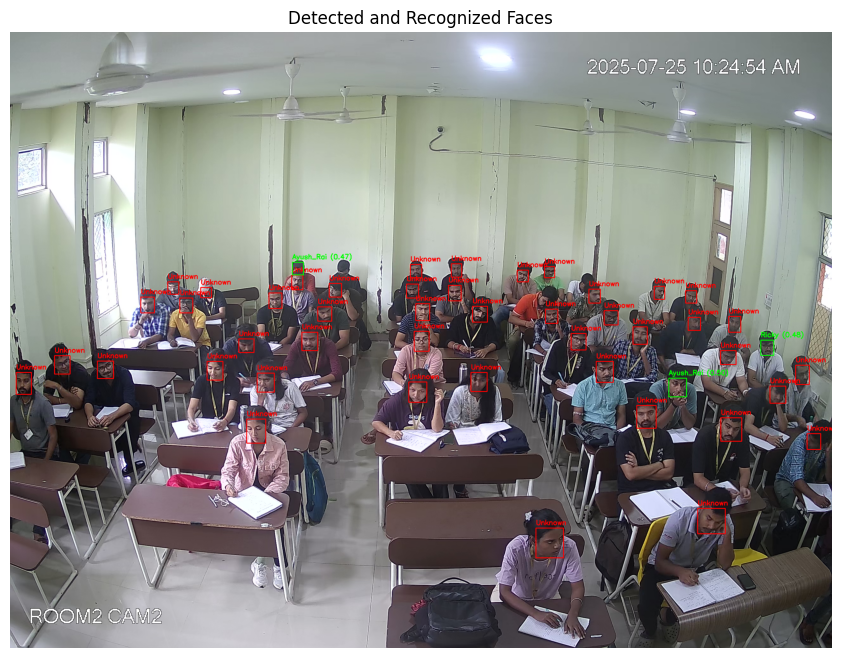

No test runs found. Run cell 13 first to generate detections.


In [ ]:
# STEP 5: Recognition utilities and batch matcher

def recognize_face(embedding, known_faces, threshold=0.4):
    best_match = None
    highest_sim = -1.0
    # Normalize input embedding
    denom = np.linalg.norm(embedding) + 1e-9
    embedding = embedding / denom
    for name, known_emb in known_faces:
        ke = known_emb / (np.linalg.norm(known_emb) + 1e-9)
        sim = float(np.dot(embedding, ke))
        if sim > highest_sim and sim > threshold:
            best_match = name
            highest_sim = sim
    return best_match, highest_sim

# 1) If faces variable exists (image flow), annotate current image as before
if 'faces' in globals() and 'image' in globals():
    for face in faces:
        emb = face.embedding
        name, sim = recognize_face(emb, known_faces)
        x1, y1, x2, y2 = map(int, face.bbox)
        color = (0, 255, 0) if name else (0, 0, 255)
        label = f"{name} ({sim:.2f})" if name else "Unknown"
        print(f"Face recognized as: {label}")
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected and Recognized Faces")
    plt.show()

# 2) Batch recognize over outputs from STEP 4 (cell 13)
import json, os
try:
    meta_path = os.path.join(FACE_DB, "_test_runs")
    # pick the latest run folder (if any)
    if os.path.isdir(meta_path):
        runs = sorted([os.path.join(meta_path, d) for d in os.listdir(meta_path)], reverse=True)
    else:
        runs = []

    if runs:
        run_dir = runs[0]
        with open(os.path.join(run_dir, "meta.json"), "r", encoding="utf-8") as f:
            meta = json.load(f)
        print(f"Loaded test run from: {run_dir}")

        # For each detection, load embedding and classify
        results = []
        for det in meta.get("detections", []):
            emb = np.load(det["emb_path"]) if os.path.exists(det["emb_path"]) else None
            if emb is None:
                continue
            name, sim = recognize_face(emb, known_faces)
            results.append({
                **det,
                "match": name if name else "Unknown",
                "similarity": float(sim)
            })

        # Print a compact summary
        hit = sum(1 for r in results if r["match"] != "Unknown")
        print(f"Batch results: {hit}/{len(results)} recognized above threshold")

        # If annotated image/video exists, we can’t easily overlay names post-hoc here without re-rendering.
        # Optionally, copy a CSV-style summary next to outputs.
        import csv
        summary_csv = os.path.join(run_dir, "matches.csv")
        with open(summary_csv, "w", newline="", encoding="utf-8") as fcsv:
            writer = csv.DictWriter(fcsv, fieldnames=["frame_idx","bbox","crop_path","emb_path","match","similarity"])
            writer.writeheader()
            for r in results:
                writer.writerow(r)
        print(f"Match summary saved: {summary_csv}")
    else:
        print("No test runs found. Run cell 13 first to generate detections.")
except Exception as e:
    print(f"Batch recognition skipped due to error: {e}")
